In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

preprocess_path = "/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/"
train_files = glob(os.path.join(preprocess_path, "*.jpeg"))
input_path = "/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy"
df = pd.read_csv(os.path.join(input_path, "trainLabels.csv"))

In [2]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), 
        iaa.Affine(
            scale=(0.9, 1.1),
            rotate=(-180, 180), 
        ),
    ],
    random_order=True
)

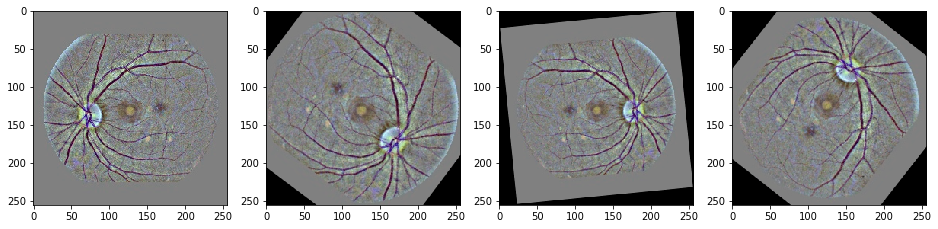

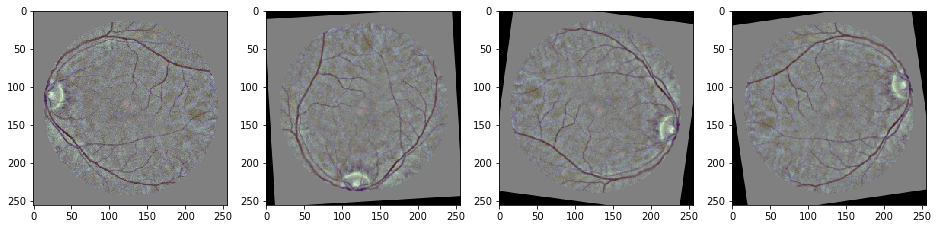

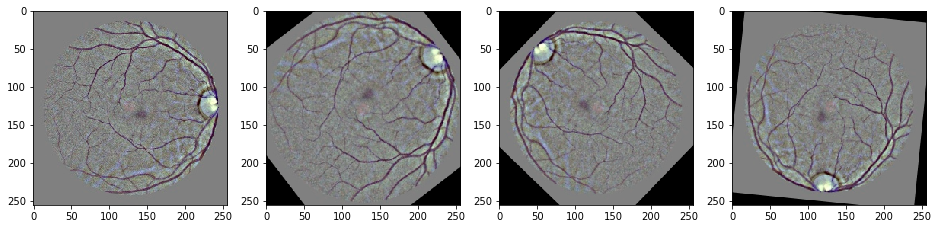

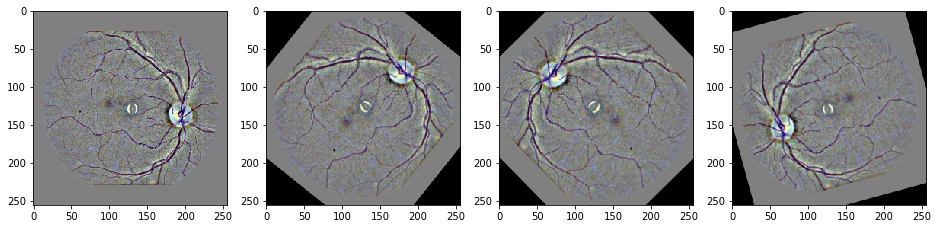

In [3]:
def show_augmented_images7351(img_file):
    img = cv2.imread(img_file)
    imgs = [img] + seq.augment_images([img for x in range(7)])

    plt.figure(figsize=(16, 6))
    for i in range(0, 4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[i])
        
show_augmented_images(train_files[0])
show_augmented_images(train_files[1])
show_augmented_images(train_files[2])
show_augmented_images(train_files[3])

In [11]:
def get_level(file, df):
    basename = os.path.basename(file)
    image_id = basename.split(".")[0]

    mini_df = df[df['image'] == image_id]
    if len(mini_df) < 1:
        return None

    return mini_df.values[0][1]

#count_level=[0 for i in range(5)]
# Example: 1 -> [0, 1, 0, 0, 0]
def get_onehot(level,count):
    level_vec = np.zeros(2)
    if(level==0):
        level_vec[level] = 1
    else:
        level_vec[1]=1
        count+=1
        #print("please..")
    #count_level[level]+=1
    return level_vec

In [21]:
class DataSequence(tf.keras.utils.Sequence):
    def __init__(self, file_list, batch_size, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        count=0
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file, df)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level,count))
                #class_weights= [0:0.01, 1:0.2,2:0.220,3:0.270,4:0.3]
                #class_weights = get_class_weights(current_epoch)
            if(count!=0):
                print(count)
            i += 1
        # Image augmentation
        #if self.augment:
        #    imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

In [13]:
# from tf.keras.models import Sequential
# from tf.keras.layers.core import Dense, Flatten
# from tf.keras.layers.convolutional import Conv2D
# from tf.keras.layers.pooling import MaxPooling2D
# from tf.keras.optimizers import SGD
# from tf.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from datetime import datetime as dt
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'base_{}'.format(time_str)

    return experiment_id
def get_model(input_dim):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_dim, input_dim, 3)))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    
    #model.add(MaxPooling2D(pool_size=(0.03*10,3*10],
                              epochs=100,2, 2)))

    model.add(keras.layers.Conv2D(96, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(96, (3, 3), activation='relu'))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(192, (3, 3), activation='relu'))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))

    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [14]:
model = get_model(256)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 124, 124, 96)      27744     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 122, 122, 96)      83040     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 59, 59, 128)       110720    
__________

In [15]:
train_files = glob("/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/*jpeg")

n_val_files = len(train_files) // 10

val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

In [16]:
train_files

['/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/9840_right.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/13878_left.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/22360_right.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/14158_left.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/16283_right.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/13270_left.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/8410_right.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/39612_left.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/30769_left.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/44159_right.jpeg',
 '/home/mukeshbr/Desktop/Master/Diabetic_Retinopathy/preprocessedtrain/5784_left.jpeg',
 '/home/mukeshbr/De

In [24]:
batch_size = 16

train_gen = DataSequence(train_file_list, batch_size, augment=True)
validate_gen = DataSequence(val_file_list, batch_size, augment=True)

print(train_gen)
model = get_model(256)

experiment_id = get_experiment_id()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    keras.callbacks.ModelCheckpoint(experiment_id + "new-val_loss_checkpoint.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=len(train_gen),
                              validation_steps=len(validate_gen),
                              verbose=1,
                              class_weight=[0.03*10,3*10],
                              epochs=100,
                              callbacks=callbacks,
                              workers=8, # recommend: number of cpu cores
                              use_multiprocessing=True)

Epoch 1/10
1974/1975 [============================>.] - ETA: 0s - loss: 4.2703 - acc: 0.7347
Epoch 00001: val_loss improved from inf to 4.33772, saving model to base_2019-03-20-19-51-21new-val_loss_checkpoint.hdf5
1975/1975 [==============================] - 771s 390ms/step - loss: 4.2687 - acc: 0.7348 - val_loss: 4.3377 - val_acc: 0.7309
Epoch 2/10
1974/1975 [============================>.] - ETA: 0s - loss: 4.2704 - acc: 0.7351
Epoch 00002: val_loss did not improve from 4.33772
1975/1975 [==============================] - 756s 383ms/step - loss: 4.2698 - acc: 0.7351 - val_loss: 4.3377 - val_acc: 0.7309
Epoch 3/10
1974/1975 [============================>.] - ETA: 0s - loss: 4.2699 - acc: 0.7351
Epoch 00003: val_loss did not improve from 4.33772
1975/1975 [==============================] - 761s 386ms/step - loss: 4.2698 - acc: 0.7351 - val_loss: 4.3377 - val_acc: 0.7309
Epoch 4/10
1974/1975 [============================>.] - ETA: 0s - loss: 4.2694 - acc: 0.7351
Epoch 00004: val_loss di

In [17]:
model=keras.models.load_model("base_2019-03-13-17-54-44-val_loss_checkpoint.hdf5")